In [3]:
import Constants as c           # constants
import polars as pl             # polars
import os                       # for reading local files and folders
import zipfile                  # for handling zip files
from collections import Counter # for stats analysis on the dataframe  
import math                     # for math functions
import matplotlib.pyplot as plt # for plotting
import statistics as stats      # for statistics functions

Extract only the data with the correct latitude and longitude values</br>
This operation takes roughly 15-20 seconds per csv file (tested on csv files with > 1 million rows)</br>

In [4]:
final_df = pl.DataFrame()

# list all the valid files
valid_filenames = [f for f in os.listdir(c.FOLDER_PATH) if f.startswith('AIS')]
valid_filenames.sort()
csv_filenames = [f.removesuffix('.csv') for f in valid_filenames if f.endswith('.csv')]
zip_filenames = [f.removesuffix('.zip') for f in valid_filenames if f.endswith('.zip')]

to_unzip_filenames = [f + '.zip' for f in zip_filenames if not(f in csv_filenames)]

for zip_name in zip_filenames:
    csv_name = zip_name.removesuffix('.zip') + '.csv'
    if zip_name in to_unzip_filenames:    
        with zipfile.ZipFile(c.FOLDER_PATH + zip_name, 'r') as z:
            z.extractall(c.FOLDER_PATH)
    full_df = pl.read_csv(source=c.FOLDER_PATH + csv_name,
                          try_parse_dates=True,
                          low_memory = True
                          )
    filtered_df = full_df.filter(
                                    (pl.col('LAT').is_between(c.LAT_MIN, c.LAT_MAX, closed='none')) &
                                    (pl.col('LON').is_between(c.LON_MIN, c.LON_MAX, closed='none'))
                                 )

    final_df = pl.concat([final_df, filtered_df], how='vertical')

print(final_df.shape)


(5462415, 17)


Separate code snippet used for exporting the final dataframe as a csv file.</br>
This is necessary as the above code snippet takes a while to read and filter several csv files.</br>
By exporting the resulting df as a csv file it's possible import it again for the following part of this notebook.</br>

In [5]:
#OUTPUT_PATH = os.getcwd() # returns current working dir
OUTPUT_PATH = c.FOLDER_PATH
FILE_NAME = '2019_01-03.csv' #specify file name (.csv extension necessary)

# export the full, uncleaned csv for backup purposes
final_df.write_csv(OUTPUT_PATH + '/' + FILE_NAME)

print(f"Dataframe shape: {final_df.shape}")

Dataframe shape: (5462415, 17)


Read the csv file and use it as the final data source</br>
(The code snippet below should be used only if the code snippet #2 was not executed)

In [6]:
# read csv
final_df = pl.read_csv(OUTPUT_PATH + FILE_NAME)
print(f'Rows, col before: {final_df.shape}')
final_df = final_df.unique()
print(f'Rows, col after: {final_df.shape}')

Rows, col before: (5462415, 17)
Rows, col after: (5460800, 17)


Some stats about the imported dataframe</br>
In order to make the histogram below, occurrencies are rounded to the top hundred (ex: 33 -> 100, 244 -> 300, etc...)</br>
This is done in order to have an idea about how many ships have negligible amount of records.</br>
In the following code snippet the threshold is set to 100 and consequently all vessels with less than 100 data points are removed from the dataset</br>

Avg entries for each vessel 9071.09634551495
Variance: 216596411.76774037
Standard Deviation: 14717.214810137833
Max entries found for the same ship: 82554
Min entries found for the same ship: 1


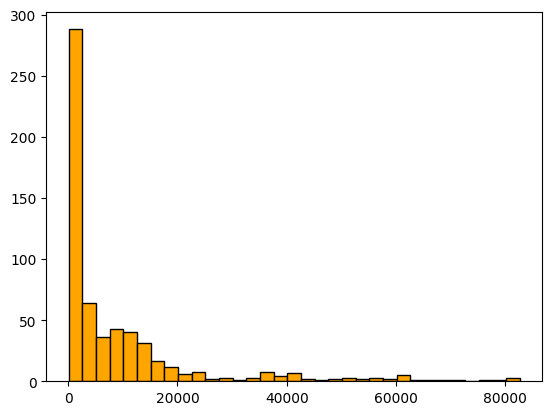

In [7]:
# Extract all the unique MMSIs
unique_mmsis = final_df['MMSI'].unique()

# Calculate the exact number of entries for each ship

vessels_entries_dict = dict(Counter(final_df['MMSI'].to_list()))
vessel_entries = list(vessels_entries_dict.values())
vessel_entries.sort()
rounded_vessel_entries = [math.ceil(x/100) * 100 for x in vessel_entries]

print(f"Avg entries for each vessel {stats.mean(vessel_entries)}")
print(f"Variance: {stats.variance(vessel_entries)}")
print(f"Standard Deviation: {stats.stdev(vessel_entries)}")
print(f"Max entries found for the same ship: {vessel_entries[-1]}")
print(f"Min entries found for the same ship: {vessel_entries[0]}")

n, bins, patches = plt.hist(x=rounded_vessel_entries, bins='auto', color='orange', edgecolor = 'black')

Remove ships with not enough points

In [8]:
THRESHOLD = int(stats.mean(vessel_entries) * 0.1)  # 10% of the average entries per ship
print(f'Threshold: {THRESHOLD} rows')
# find the MMSIs of all the ships with more than THRESHOLD points
mmsi_to_be_kept = [x for x in vessels_entries_dict.keys() if vessels_entries_dict[x] > THRESHOLD]
print(f"Final dataframe len: {final_df.shape[0]}, num of vessels: {len(vessel_entries)}, num of vessels: {len(mmsi_to_be_kept)}")

clean_df = pl.DataFrame()
for mmsi in mmsi_to_be_kept:    
    temp_df = final_df.filter(pl.col('MMSI') == mmsi)
    clean_df = pl.concat([clean_df, temp_df])
    
print(f"Cleaned dataframe len: {clean_df.shape[0]}, num of vessels: {len(clean_df['MMSI'].unique())}")
print(f'Percentage of row dropped/total rows = {round((final_df.shape[0] - clean_df.shape[0])/final_df.shape[0] * 100, 2)}%')

Threshold: 907 rows
Final dataframe len: 5460800, num of vessels: 602, num of vessels: 403
Cleaned dataframe len: 5415168, num of vessels: 403
Percentage of row dropped/total rows = 0.84%


Export the cleaned dataframe in order to have a backup copy in a csv file

In [9]:
#OUTPUT_PATH = os.getcwd()
OUTPUT_PATH = c.FOLDER_PATH
clean_df.write_csv(OUTPUT_PATH + '/cleaned_' + FILE_NAME)

print(f"Dataframe shape: {clean_df.shape}")

Dataframe shape: (5415168, 17)


Create a new histogram using the "cleaned" data from the clean_df

Avg entries for each vessel 13437.141439205956
Variance: 265969260.81327853
Standard Deviation: 16308.564032841105
Max entries found for the same ship: 82554
Min entries found for the same ship: 921


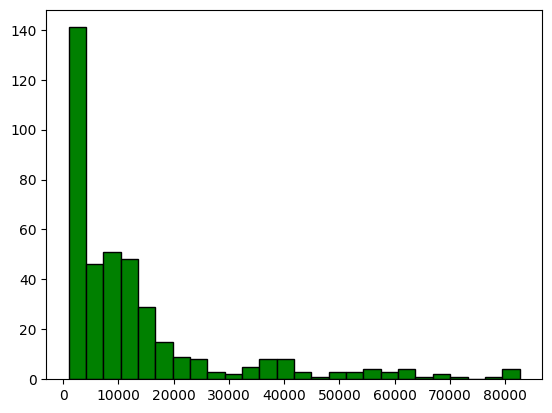

In [10]:
clean_vessel_entries = list(Counter(clean_df['MMSI'].to_list()).values())

rounded_clean_vessels_entries = [math.ceil(x/100) * 100 for x in clean_vessel_entries]

print(f"Avg entries for each vessel {stats.mean(clean_vessel_entries)}")
print(f"Variance: {stats.variance(clean_vessel_entries)}")
print(f"Standard Deviation: {stats.stdev(clean_vessel_entries)}")
print(f"Max entries found for the same ship: {max(clean_vessel_entries)}")
print(f"Min entries found for the same ship: {min(clean_vessel_entries)}")

n, bins, patches = plt.hist(x=rounded_clean_vessels_entries, bins='auto', color='green', edgecolor = 'black', )